# Week 11: Exploring Character-Level Sentiment with the Project Dialogism Novel Corpus (PDNC)

This week we:
* Introduce the Project Dialogism Novel Corpus dataset (created by AH and TA Krishnapriya Vishnubhotla... with lots of help!)
* Use the PDNC and our knowledge of sentiment to ask two questions: is Sherlock Holmes the most "objective" character in the text... and is he the one with the "steadiest" emotional profile?
* For the "steadiest" question, we calculate the polarity scores for every "turn" (passage of speech) in the novel, and then take the standard deviation for each character's per-turn polarity scores.
* For the "most objective" question, we calculate the "subjectivity" scores for every turn in the novel, then calculate the average value for each character.

# Loading the PDNC data for *The Sign of the Four*

Let's import Pandas and TextBlob, then load the CSV containing the PDNC data for *The Sign of the Four*.

In [52]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

In [53]:
from textblob import TextBlob

In [54]:
sot4_pdnc_df = pd.read_csv('pdnc_sot4.csv')

As you'll see, each row consists of a sentence of narration or a "dialogue turns" (passages of character dialogue). These are sequential, in the order given in the novel.

For each row, the CSV records:
- The full text of the sentence of narration or the turn of dialogue
- A unique ID for this span
- Whether this is narraiton or character dialogue
- How far into the narraive (on a scale from 0 to 1) the passage occurs
- The identity of the speaker
- The character(s) to whom the quotation is addressed
- The type of quotation ("Explicit" means there is a speech tag that attributes the quotation to a character by name; "Implicit" means there is a speech tag that attributes the quotation to a character by pronoun; "Anaphoric" means there is no speech tag)
- The speaker type: whether narrator, major character, minor, or *very* minor (too-minor) character
- The speaker gender (`A` for ambiguous; `M` for male; `F` for female — these are all hand-coded by pairs of annotators)

In [55]:
sot4_pdnc_df

,Turn,TurnID,TurnType,narrative_time,speaker,addressee,qType,speakerType,speakerGender
0,Chapter I The Science of Deduction Sherlock Holmes took his bottle from the corner of the mantel-piece and his hypodermic syringe from its neat morocco case.,S0-0,narration,0.00000,narrator,NaN,NaN,narrator,A
1,"With his long, white, nervous fingers he adjusted the delicate needle, and rolled back his left shirt-cuff.",S1-0,narration,0.00049,narrator,NaN,NaN,narrator,A
2,For some little time his eyes rested thoughtfully upon the sinewy forearm and wrist all dotted and scarred with innumerable puncture-marks.,S2-0,narration,0.00098,narrator,NaN,NaN,narrator,A
3,"Finally he thrust the sharp point home, pressed down the tiny piston, and sank back into the velvet-lined arm-chair with a long sigh of satisfaction.",S3-0,narration,0.00147,narrator,NaN,NaN,narrator,A
4,"Three times a day for many months I had witnessed this performance, but custom had not reconciled my mind to it.",S4-0,narration,0.00196,narrator,NaN,NaN,narrator,A
...,...,...,...,...,...,...,...,...,...
2037,"You have done all the work in this business. I get a wife out of it, Jones gets the credit, pray what remains for you?",Q638-1,quote,0.99804,Dr. Watson,['Mr. Sherlock Holmes'],Anaphoric,major,A
2038,"For me,",Q639-0,quote,0.99853,Mr. Sherlock Holmes,['Dr. Watson'],Explicit,major,M
2039,"said Sherlock Holmes,",S1149-0,narration,0.99902,narrator,NaN,NaN,narrator,A
2040,there still remains the cocaine-bottle.,Q639-1,quote,0.99951,Mr. Sherlock Holmes,['Dr. Watson'],Explicit,major,M


To carry out our analysis, we're going to need sentiment polarity and subjectivity values for every row of this DataFrame. Let's do this the usual way, by building up lists of polarity and subjectivity values corresponding to each "turn" in `pdnc_sot4_df`. 

As you'll see below, it's possible to iterate through a column of a Pandas DataFrame (`Turn`) row by row. Here we going to create a TextBlob object for each of these turns, so that we can then extract polarity and subjectivity values.

In [56]:
sot4_turn_blobs = []
for turn in sot4_pdnc_df['Turn']:
    sot4_turn_blobs.append(TextBlob(turn))

In [57]:
type(sot4_turn_blobs)

list

In [58]:
type(sot4_turn_blobs[0])

textblob.blob.TextBlob

In [59]:
sot4_turn_blobs[:10]

[TextBlob("Chapter I The Science of Deduction Sherlock Holmes took his bottle from the corner of the mantel-piece and his hypodermic syringe from its neat morocco case."),
 TextBlob("With his long, white, nervous fingers he adjusted the delicate needle, and rolled back his left shirt-cuff."),
 TextBlob("For some little time his eyes rested thoughtfully upon the sinewy forearm and wrist all dotted and scarred with innumerable puncture-marks."),
 TextBlob("Finally he thrust the sharp point home, pressed down the tiny piston, and sank back into the velvet-lined arm-chair with a long sigh of satisfaction."),
 TextBlob("Three times a day for many months I had witnessed this performance, but custom had not reconciled my mind to it."),
 TextBlob("On the contrary, from day to day I had become more irritable at the sight, and my conscience swelled nightly within me at the thought that I had lacked the courage to protest."),
 TextBlob("Again and again I had registered a vow that I should deliver

Now let's build up two more lists: the polarity and subjectivity values for each turn.

In [60]:
sot4_turn_polarities = []
for turn in sot4_turn_blobs:
    sot4_turn_polarities.append(turn.polarity)

In [61]:
sot4_turn_polarities[:10]

[0.0,
 -0.06999999999999999,
 0.10625000000000001,
 -0.05509259259259259,
 0.5,
 0.5,
 0.04583333333333333,
 0.35833333333333334,
 -0.0625,
 0.0]

In [62]:
sot4_turn_subjectivities = []
for turn in sot4_turn_blobs:
    sot4_turn_subjectivities.append(turn.subjectivity)

In [63]:
sot4_turn_subjectivities[:10]

[0.0, 0.26, 0.5, 0.48981481481481476, 0.5, 0.5, 0.2625, 0.7625, 0.75, 0.0]

Using the same technique we've been using for the past few weeks, let's now create new columns in the `pdnc_sot4_df` DataFrame from the data in the two lists we just created.

In [64]:
sot4_pdnc_df['polarity'] = sot4_turn_polarities
sot4_pdnc_df['subjectivity'] = sot4_turn_subjectivities

In [65]:
sot4_pdnc_df

,Turn,TurnID,TurnType,narrative_time,speaker,addressee,qType,speakerType,speakerGender,polarity,subjectivity
0,Chapter I The Science of Deduction Sherlock Holmes took his bottle from the corner of the mantel-piece and his hypodermic syringe from its neat morocco case.,S0-0,narration,0.00000,narrator,NaN,NaN,narrator,A,0.000000,0.000000
1,"With his long, white, nervous fingers he adjusted the delicate needle, and rolled back his left shirt-cuff.",S1-0,narration,0.00049,narrator,NaN,NaN,narrator,A,-0.070000,0.260000
2,For some little time his eyes rested thoughtfully upon the sinewy forearm and wrist all dotted and scarred with innumerable puncture-marks.,S2-0,narration,0.00098,narrator,NaN,NaN,narrator,A,0.106250,0.500000
3,"Finally he thrust the sharp point home, pressed down the tiny piston, and sank back into the velvet-lined arm-chair with a long sigh of satisfaction.",S3-0,narration,0.00147,narrator,NaN,NaN,narrator,A,-0.055093,0.489815
4,"Three times a day for many months I had witnessed this performance, but custom had not reconciled my mind to it.",S4-0,narration,0.00196,narrator,NaN,NaN,narrator,A,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
2037,"You have done all the work in this business. I get a wife out of it, Jones gets the credit, pray what remains for you?",Q638-1,quote,0.99804,Dr. Watson,['Mr. Sherlock Holmes'],Anaphoric,major,A,0.000000,0.000000
2038,"For me,",Q639-0,quote,0.99853,Mr. Sherlock Holmes,['Dr. Watson'],Explicit,major,M,0.000000,0.000000
2039,"said Sherlock Holmes,",S1149-0,narration,0.99902,narrator,NaN,NaN,narrator,A,0.000000,0.000000
2040,there still remains the cocaine-bottle.,Q639-1,quote,0.99951,Mr. Sherlock Holmes,['Dr. Watson'],Explicit,major,M,0.000000,0.000000


Let's have a look at Holmes's most positive and negative turns, as well as his most- and least-subjective turns, as seen by TextBlob's sentiment system. We'll use the technique learned in last week's lecture...

In [66]:
sot4_pdnc_df[sot4_pdnc_df['speaker']=='Mr. Sherlock Holmes'].sort_values(by='polarity', ascending=False).head(10)

,Turn,TurnID,TurnType,narrative_time,speaker,addressee,qType,speakerType,speakerGender,polarity,subjectivity
1426,"You had best take it, then. It is well to be prepared. I see that the cab is at the door. I ordered it for half-past six.",Q449-0,quote,0.698677,Mr. Sherlock Holmes,"['Mr. Athelney Jones', 'Dr. Watson']",Implicit,major,M,1.000000,0.300000
1993,"A very remarkable account,",Q622-0,quote,0.976482,Mr. Sherlock Holmes,"['Mr. Athelney Jones', 'Dr. Watson', 'Wooden-Legged Man']",Explicit,major,M,0.975000,0.975000
1144,Isn t it gorgeous!,Q344-0,quote,0.560510,Mr. Sherlock Holmes,['Dr. Watson'],Explicit,major,M,0.875000,0.900000
1396,"Never mind. We shall give you two others in the place of them. But you must put yourself under my orders. You are welcome to all the official credit, but you must act on the line that I point out. Is that agreed?",Q433-0,quote,0.683978,Mr. Sherlock Holmes,"['Mr. Athelney Jones', 'Dr. Watson']",Implicit,major,M,0.800000,0.900000
823,"Your presence will be of great service to me,",Q227-0,quote,0.403234,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.800000,0.750000
1103,"My dear fellow, it would be a colossal task. She may have touched at any wharf on either side of the stream between here and Greenwich. Below the bridge there is a perfect labyrinth of landing-places for miles. It would take you days and days to exhaust them, if you set about it alone.",Q331-0,quote,0.540421,Mr. Sherlock Holmes,['Dr. Watson'],Implicit,major,M,0.650000,0.900000
673,"Quite so. But there has been some one else, a very able and efficient ally. Could you scale that wall, doctor?",Q168-0,quote,0.329740,Mr. Sherlock Holmes,['Dr. Watson'],Implicit,major,M,0.650000,0.812500
924,"Quite so. That is the point. Bear that in mind. Now, would you kindly step over to that flap-window and smell the edge of the wood-work? I shall stay here, as I have this handkerchief in my hand.",Q251-0,quote,0.452719,Mr. Sherlock Holmes,['Dr. Watson'],Implicit,major,M,0.600000,0.900000
180,"The envelope too, please. Postmark, London, S.W. Date, July 7. Hum! Man s thumb-mark on corner, probably postman. Best quality paper. Envelopes at sixpence a packet. Particular man in his stationery. No address.",Q63-1,quote,0.088192,Mr. Sherlock Holmes,"['Dr. Watson', 'Miss Morstan']",Explicit,major,M,0.583333,0.316667
1066,"Here you are, then! Catch! A fine child, Mrs. Smith!",Q304-0,quote,0.522293,Mr. Sherlock Holmes,"['Mrs. Smith', 'Dr. Watson', 'Jack']",Implicit,major,M,0.520833,0.500000


In [67]:
sot4_pdnc_df[sot4_pdnc_df['speaker']=='Mr. Sherlock Holmes'].sort_values(by='polarity', ascending=True).head(10)

,Turn,TurnID,TurnType,narrative_time,speaker,addressee,qType,speakerType,speakerGender,polarity,subjectivity
1050,"This looks bad,",Q298-0,quote,0.514454,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,-0.700000,0.666667
1153,"No, it s not quite so bad as that. It is the unofficial force, the Baker Street irregulars.",Q348-0,quote,0.564919,Mr. Sherlock Holmes,['Dr. Watson'],Implicit,major,M,-0.700000,0.666667
1070,"I am sorry for that, for I wanted to speak to Mr. Smith.",Q306-1,quote,0.524253,Mr. Sherlock Holmes,"['Mrs. Smith', 'Dr. Watson', 'Jack']",Explicit,major,M,-0.500000,1.000000
1593,I am sorry that it has come to this.,Q488-1,quote,0.780500,Mr. Sherlock Holmes,"['Dr. Watson', 'Wooden-Legged Man']",Explicit,major,M,-0.500000,1.000000
244,"There is no great mystery in this matter,",Q82-2,quote,0.119549,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,-0.400000,0.750000
1169,"They can go everywhere, see everything, overhear every one. I expect to hear before evening that they have spotted her. In the meanwhile, we can do nothing but await results. We cannot pick up the broken trail until we find either the Aurora or Mr. Mordecai Smith.",Q353-1,quote,0.572758,Mr. Sherlock Holmes,['Dr. Watson'],Explicit,major,M,-0.400000,0.400000
745,"just put your hand here on this poor fellow s arm, and here on his leg. What do you feel?",Q189-1,quote,0.365017,Mr. Sherlock Holmes,['Dr. Watson'],Explicit,major,M,-0.400000,0.600000
116,"pray accept my apologies. Viewing the matter as an abstract problem, I had forgotten how personal and painful a thing it might be to you. I assure you, however, that I never even knew that you had a brother until you handed me the watch.",Q36-1,quote,0.056835,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,-0.350000,0.600000
698,"How often have I said to you that when you have eliminated the impossible whatever remains, however improbable_, must be the truth? We know that he did not come through the door, the window, or the chimney. We also know that he could not have been concealed in the room, as there is no concealment possible. Whence, then, did he come?",Q176-1,quote,0.341989,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,-0.333333,1.000000
996,"It is just possible that we may need something of the sort if we get to their lair. Jonathan I shall leave to you, but if the other turns nasty I shall shoot him dead.",Q287-0,quote,0.487996,Mr. Sherlock Holmes,['Dr. Watson'],Implicit,major,M,-0.331250,0.693750


In [68]:
sot4_pdnc_df[sot4_pdnc_df['speaker']=='Mr. Sherlock Holmes'].sort_values(by='subjectivity', ascending=False).head(10)

,Turn,TurnID,TurnType,narrative_time,speaker,addressee,qType,speakerType,speakerGender,polarity,subjectivity
634,"It is a thorn. You may pick it out. But be careful, for it is poisoned.",Q155-0,quote,0.310632,Mr. Sherlock Holmes,"['Dr. Watson', 'A High Piping Voice']",Implicit,major,M,-0.100000,1.0
698,"How often have I said to you that when you have eliminated the impossible whatever remains, however improbable_, must be the truth? We know that he did not come through the door, the window, or the chimney. We also know that he could not have been concealed in the room, as there is no concealment possible. Whence, then, did he come?",Q176-1,quote,0.341989,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,-0.333333,1.0
1070,"I am sorry for that, for I wanted to speak to Mr. Smith.",Q306-1,quote,0.524253,Mr. Sherlock Holmes,"['Mrs. Smith', 'Dr. Watson', 'Jack']",Explicit,major,M,-0.500000,1.0
1368,Pretty sort o treatment this!,Q423-0,quote,0.670260,Mr. Sherlock Holmes,"['Mr. Athelney Jones', 'Dr. Watson']",Anaphoric,major,M,0.312500,1.0
741,"I know a dog that would follow that scent to the world s end. If a pack can track a trailed herring across a shire, how far can a specially-trained hound follow so pungent a smell as this? It sounds like a sum in the rule of three. The answer should give us the But halloa! here are the accredited representatives of the law.",Q188-1,quote,0.363057,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.125000,1.0
246,The facts appear to admit of only one explanation.,Q82-3,quote,0.120529,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.000000,1.0
1593,I am sorry that it has come to this.,Q488-1,quote,0.780500,Mr. Sherlock Holmes,"['Dr. Watson', 'Wooden-Legged Man']",Explicit,major,M,-0.500000,1.0
811,"Is a rather curious person,",Q222-0,quote,0.397354,Mr. Sherlock Holmes,"['A High Piping Voice', 'Dr. Watson', 'Mr. Athelney Jones', 'Inspector In Uniform']",Explicit,major,M,-0.100000,1.0
33,"The only unofficial consulting detective,",Q7-0,quote,0.016169,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.000000,1.0
815,"This unexpected occurrence,",Q223-0,quote,0.399314,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.100000,1.0


In [69]:
sot4_pdnc_df[sot4_pdnc_df['speaker']=='Mr. Sherlock Holmes'].sort_values(by='subjectivity', ascending=True).head(10)

,Turn,TurnID,TurnType,narrative_time,speaker,addressee,qType,speakerType,speakerGender,polarity,subjectivity
13,"It is cocaine,",Q1-0,quote,0.006369,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.0,0.0
916,Do you observe anything noteworthy about them?,Q245-1,quote,0.448800,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.0,0.0
920,"Apart from their size, though. Is there nothing else?",Q247-0,quote,0.450759,Mr. Sherlock Holmes,['Dr. Watson'],Implicit,major,M,0.0,0.0
930,"That you, Watson?",Q253-0,quote,0.455659,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.0,0.0
2038,"For me,",Q639-0,quote,0.998530,Mr. Sherlock Holmes,['Dr. Watson'],Explicit,major,M,0.0,0.0
937,No sign of a ladder?,Q259-0,quote,0.459089,Mr. Sherlock Holmes,['Dr. Watson'],Implicit,major,M,0.0,0.0
948,"They are hellish things,",Q263-0,quote,0.464478,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.0,0.0
953,Your leg will stand it?,Q265-0,quote,0.466928,Mr. Sherlock Holmes,['Dr. Watson'],Implicit,major,M,0.0,0.0
966,"There s the print of wooden-leg s hand,",Q268-0,quote,0.473297,Mr. Sherlock Holmes,['Dr. Watson'],Anaphoric,major,M,0.0,0.0
973,"Do not imagine,",Q269-0,quote,0.476727,Mr. Sherlock Holmes,['Dr. Watson'],Explicit,major,M,0.0,0.0


# Standard Deviation

At this point, Mary will give us a short lecture explaining how standard deviation works.

# Grouping Turns by Speaker and Calculating Standard Deviation of Polarity and Mean of Subjectivity

Let's use techniques first learned in Week 9 to group our `pdnc_sot4_df` DataFrame by `speaker`, and the calculate some statistics on the `polarity` and `subjectivity` columns.

In [70]:
sot4_pdnc_by_speaker = sot4_pdnc_df.groupby('speaker')

In [71]:
sot4_pdnc_by_speaker.describe()

narrative_time                                \
                                   count      mean       std       min   
speaker                                                                  
A Bluff, Genial Inspector  4.0            0.839539  0.002059  0.837335   
A Hindoo Servant           1.0            0.157276 NaN        0.157276   
A Small, Dark, Brisk Man   3.0            0.142087  0.001767  0.140127   
Dr. Watson                 196.0          0.452619  0.275406  0.004410   
Inspector In Uniform       1.0            0.390495 NaN        0.390495   
Jack                       2.0            0.520578  0.001039  0.519843   
Jonathan Small             107.0          0.906171  0.052169  0.780990   
Mcmurdo                    9.0            0.252164  0.004544  0.244978   
Miss Morstan               51.0           0.380628  0.333565  0.068594   
Mr. Athelney Jones         67.0           0.647210  0.179980  0.373836   
Mr. Sherlock Holmes        350.0          0.434416  0.254704  0.006369   
Mr. Sherman                11.0           0.431829  0.004042  0.425772   
Mr. Thaddeus Sholto        59.0           0.221336  0.048412  0.158256   
Mrs. Bernstone             5.0            0.280353  0.006448  0.268986   
Mrs. Cecil Forrester       3.0            0.603789  0.001233  0.602646   
Mrs. Hudson                5.0            0.502107  0.245630  0.062714   
Mrs. Smith                 14.0           0.528102  0.006191  0.516414   
Wiggins                    3.0            0.568186  0.001497  0.566879   
narrator                   1151.0         0.504111  0.289344  0.000000   

                                                                  polarity  \
                                25%       50%       75%       max    count   
speaker                                                                      
A Bluff, Genial Inspector  0.838070  0.839539  0.841009  0.841744  4.0       
A Hindoo Servant           0.157276  0.157276  0.157276  0.157276  1.0       
A Small, Dark, Brisk Man   0.141352  0.142577  0.143067  0.143557  3.0       
Dr. Watson                 0.290421  0.480892  0.647967  0.998040  196.0     
Inspector In Uniform       0.390495  0.390495  0.390495  0.390495  1.0       
Jack                       0.520211  0.520578  0.520946  0.521313  2.0       
Jonathan Small             0.862812  0.917687  0.944145  0.983341  107.0     
Mcmurdo                    0.248408  0.252327  0.255267  0.258207  9.0       
Miss Morstan               0.092602  0.175404  0.806957  0.834885  51.0      
Mr. Athelney Jones         0.395884  0.684468  0.765311  0.985301  67.0      
Mr. Sherlock Holmes        0.262004  0.457619  0.613180  0.999510  350.0     
Mr. Sherman                0.428711  0.431651  0.435081  0.437531  11.0      
Mr. Thaddeus Sholto        0.183244  0.217540  0.250367  0.391965  59.0      
Mrs. Bernstone             0.281725  0.282705  0.283684  0.284664  5.0       
Mrs. Cecil Forrester       0.603136  0.603626  0.604361  0.605096  3.0       
Mrs. Hudson                0.610485  0.611465  0.612445  0.613425  5.0       
Mrs. Smith                 0.524988  0.529152  0.532827  0.536012  14.0      
Wiggins                    0.567369  0.567859  0.568839  0.569819  3.0       
narrator                   0.242283  0.499755  0.763106  1.000000  1151.0    

                                     ...                    subjectivity  \
                               mean  ...       75%      max        count   
speaker                              ...                                   
A Bluff, Genial Inspector -0.100000  ...  0.075000  0.30000  4.0           
A Hindoo Servant           0.000000  ...  0.000000  0.00000  1.0           
A Small, Dark, Brisk Man  -0.016667  ...  0.000000  0.00000  3.0           
Dr. Watson                 0.045014  ...  0.100000  1.00000  196.0         
Inspector In Uniform       0.000000  ...  0.000000  0.00000  1.0           
Jack                       0.250000  ...  0.375000  0.50000  2.0        

In [72]:
sot4_pdnc_by_speaker['polarity'].std()

speaker
A Bluff, Genial Inspector    0.424264
A Hindoo Servant            NaN      
A Small, Dark, Brisk Man     0.028868
Dr. Watson                   0.223048
Inspector In Uniform        NaN      
Jack                         0.353553
Jonathan Small               0.143431
Mcmurdo                      0.233159
Miss Morstan                 0.248818
Mr. Athelney Jones           0.247242
Mr. Sherlock Holmes          0.211043
Mr. Sherman                  0.248926
Mr. Thaddeus Sholto          0.249681
Mrs. Bernstone               0.347244
Mrs. Cecil Forrester         0.222815
Mrs. Hudson                  0.279087
Mrs. Smith                   0.193392
Wiggins                      0.072169
narrator                     0.212887
Name: polarity, dtype: float64

In [73]:
sot4_pdnc_speaker_polarity_std = sot4_pdnc_by_speaker['polarity'].std()

In [74]:
type(sot4_pdnc_speaker_polarity_std)

pandas.core.series.Series

In [75]:
sot4_pdnc_by_speaker['subjectivity'].mean()

speaker
A Bluff, Genial Inspector    0.191667
A Hindoo Servant             0.000000
A Small, Dark, Brisk Man     0.016667
Dr. Watson                   0.249907
Inspector In Uniform         0.000000
Jack                         0.250000
Jonathan Small               0.287944
Mcmurdo                      0.246102
Miss Morstan                 0.309347
Mr. Athelney Jones           0.325473
Mr. Sherlock Holmes          0.327089
Mr. Sherman                  0.265693
Mr. Thaddeus Sholto          0.325035
Mrs. Bernstone               0.515000
Mrs. Cecil Forrester         0.328571
Mrs. Hudson                  0.424722
Mrs. Smith                   0.308883
Wiggins                      0.250000
narrator                     0.278059
Name: subjectivity, dtype: float64

In [76]:
sot4_pdnc_speaker_subjectivity_mean = sot4_pdnc_by_speaker['subjectivity'].mean()

Just as we can make a DataFrame from parallel lists, so too can we make one from parallel Series. The syntax is the same as we've been using in previous weeks.

In [77]:
sot4_speaker_sentiment_stats = pd.DataFrame({
    'std_polarity': sot4_pdnc_speaker_polarity_std,
    'mean_subjectivity': sot4_pdnc_speaker_subjectivity_mean
})

In [78]:
sot4_speaker_sentiment_stats

,std_polarity,mean_subjectivity
speaker,,
"A Bluff, Genial Inspector",0.424264,0.191667
A Hindoo Servant,NaN,0.000000
"A Small, Dark, Brisk Man",0.028868,0.016667
Dr. Watson,0.223048,0.249907
Inspector In Uniform,NaN,0.000000
Jack,0.353553,0.250000
Jonathan Small,0.143431,0.287944
Mcmurdo,0.233159,0.246102
Miss Morstan,0.248818,0.309347


In [79]:
sot4_speaker_sentiment_stats.sort_values(by='std_polarity', ascending=True)

,std_polarity,mean_subjectivity
speaker,,
"A Small, Dark, Brisk Man",0.028868,0.016667
Wiggins,0.072169,0.250000
Jonathan Small,0.143431,0.287944
Mrs. Smith,0.193392,0.308883
Mr. Sherlock Holmes,0.211043,0.327089
narrator,0.212887,0.278059
Mrs. Cecil Forrester,0.222815,0.328571
Dr. Watson,0.223048,0.249907
Mcmurdo,0.233159,0.246102


In [80]:
sot4_speaker_sentiment_stats.sort_values(by='mean_subjectivity', ascending=True)

,std_polarity,mean_subjectivity
speaker,,
A Hindoo Servant,NaN,0.000000
Inspector In Uniform,NaN,0.000000
"A Small, Dark, Brisk Man",0.028868,0.016667
"A Bluff, Genial Inspector",0.424264,0.191667
Mcmurdo,0.233159,0.246102
Dr. Watson,0.223048,0.249907
Jack,0.353553,0.250000
Wiggins,0.072169,0.250000
Mr. Sherman,0.248926,0.265693


<AxesSubplot:xlabel='speaker'>

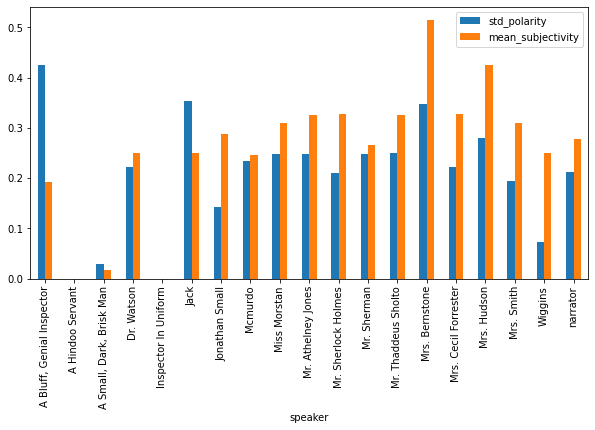

In [81]:
sot4_speaker_sentiment_stats.plot(kind='bar', figsize=(10,5))